In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [3]:
import sys

#carga de datos
sys.path.append('D:\Proyectos Personales ML\Fraud detection\data\processed\data_processed.csv')



In [4]:
DATA_PATH = r'D:\Proyectos Personales ML\Fraud detection\data\processed\data_processed.csv'
df = pd.read_csv(DATA_PATH)
df.head(5)

,V14,V10,V4,V12,V1,Class
0,-1.054631,-0.597739,0.716564,-0.216435,1.314539,0
1,0.573006,0.170547,0.694584,0.468322,-0.798672,0
2,-0.338340,2.051312,-1.308725,-0.594037,-0.391128,0
3,-0.436671,-1.238598,-0.029567,-0.586472,-0.060302,0
4,1.323225,1.166335,3.866438,-1.920966,1.848433,0


In [5]:
#separar features y target
X= df.drop('Class', axis=1)
y= df['Class']

In [6]:
#separacion de datos
X_train,X_test, y_train, y_test =train_test_split(X,y, test_size= 0.20, random_state= 42, stratify= y)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score)
from sklearn.model_selection import ParameterGrid

In [8]:
def evaluate_models(models_dict, X_train, X_test, y_train, y_test):
    """
    Evalúa múltiples modelos y retorna sus métricas
    
    Args:
        models_dict: Diccionario de modelos {nombre: modelo}
        X_train, X_test, y_train, y_test: Datos de entrenamiento y prueba
    
    Returns:
        DataFrame con métricas de cada modelo
    """
    results = []
    
    for name, model in models_dict.items():
        # Entrenar modelo
        model.fit(X_train, y_train)
        
        # Predecir
        y_pred = model.predict(X_test)
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': auc
        })
    
    return pd.DataFrame(results)

In [9]:
def grid_search_experiments(model_class, param_grid, X_train, X_test, y_train, y_test):
    """
    Experimenta con diferentes combinaciones de parámetros
    
    Args:
        model_class: Clase del modelo a experimentar
        param_grid: Diccionario con parámetros a probar
        X_train, X_test, y_train, y_test: Datos
    
    Returns:
        DataFrame con resultados de cada combinación
    """
    results = []
    
    # Generar todas las combinaciones de parámetros
    param_combinations = ParameterGrid(param_grid)
    
    for params in param_combinations:
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        results.append({
            'Parameters': params,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'AUC-ROC': roc_auc_score(y_test, y_pred)
        })
    
    return pd.DataFrame(results)

In [10]:
def plot_model_comparisons(results_df, metric='Precision'):
    """
    Visualiza comparación de modelos
    
    Args:
        results_df: DataFrame con resultados
        metric: Métrica a visualizar
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='Model', y=metric)
    plt.title(f'Comparación de Modelos - {metric}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
# 4. Definir los modelos base
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'Neural Network': MLPClassifier()
}

In [14]:
result = evaluate_models(models_dict= models, X_train= X_train, X_test= X_test, y_train= y_train, y_test= y_test)

[LightGBM] [Info] Number of positive: 22745, number of negative: 45489
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 68234, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333338 -> initscore=-0.693125
[LightGBM] [Info] Start training from score -0.693125


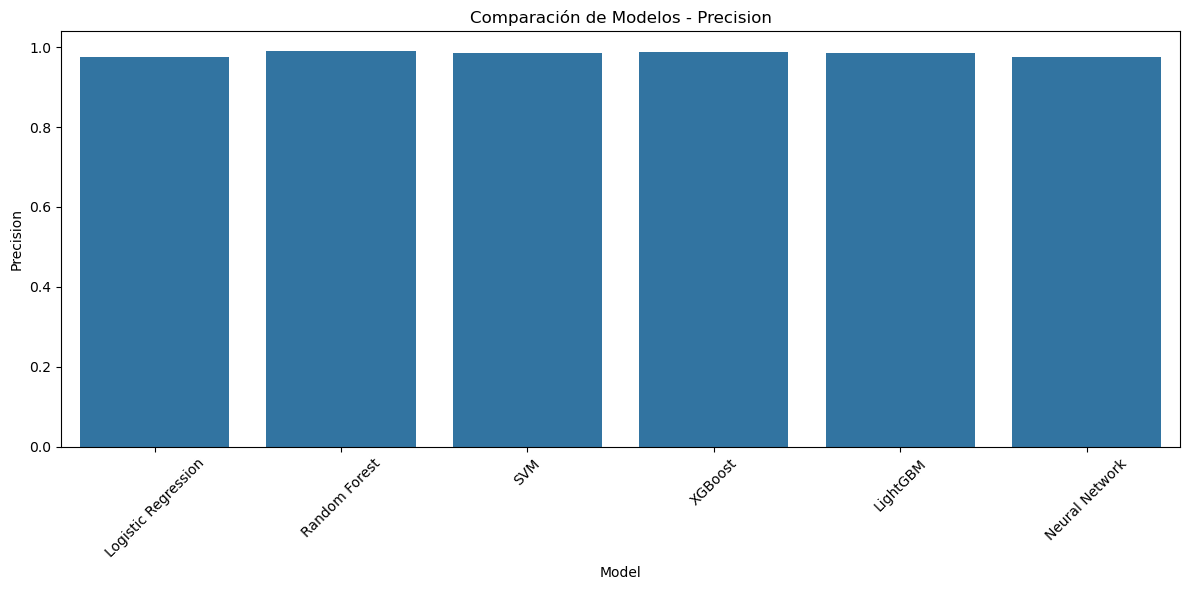

In [15]:
plot_model_comparisons(results_df= result, metric= 'Precision')

In [16]:
print(result)

                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0  Logistic Regression  0.972273   0.975205  0.940732  0.957658  0.964387
1        Random Forest  0.990679   0.990069  0.981885  0.985960  0.988481
2                  SVM  0.974149   0.984661  0.937038  0.960260  0.964870
3              XGBoost  0.989331   0.988810  0.979071  0.983917  0.986766
4             LightGBM  0.986166   0.986260  0.972037  0.979097  0.982633
5       Neural Network  0.982238   0.976119  0.970454  0.973278  0.979292


In [17]:
print("Ordenado por Accuracy:")
print(result.sort_values('Accuracy', ascending=False))

Ordenado por Accuracy:
                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
1        Random Forest  0.990679   0.990069  0.981885  0.985960  0.988481
3              XGBoost  0.989331   0.988810  0.979071  0.983917  0.986766
4             LightGBM  0.986166   0.986260  0.972037  0.979097  0.982633
5       Neural Network  0.982238   0.976119  0.970454  0.973278  0.979292
2                  SVM  0.974149   0.984661  0.937038  0.960260  0.964870
0  Logistic Regression  0.972273   0.975205  0.940732  0.957658  0.964387
